Epoch [50/500], Loss: 0.1087
Epoch [100/500], Loss: 0.0966
Epoch [150/500], Loss: 0.0779
Epoch [200/500], Loss: 0.0594
Epoch [250/500], Loss: 0.0544
Epoch [300/500], Loss: 0.0398
Epoch [350/500], Loss: 0.0275
Epoch [400/500], Loss: 0.0288
Epoch [450/500], Loss: 0.0130
Epoch [500/500], Loss: 0.0112
Epoch [50/500], Loss: 0.0010
Epoch [100/500], Loss: 0.0001
Epoch [150/500], Loss: 0.0000
Epoch [200/500], Loss: 0.0000
Epoch [250/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [350/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [450/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000
Predictions with Custom Model for new sequence: [0.9361193776130676, 0.9156574606895447, 0.9673905968666077, 0.8686169981956482, 0.8048425316810608, 0.796823263168335, 0.5981025099754333, 0.4583525061607361, 0.39570462703704834, 0.1295812577009201, -0.02345260977745056, -0.22002005577087402, -0.3531222343444824, -0.4630061388015747, -0.41606396436691284, -0.6525183916091919, -0.7011312246322632, -0.

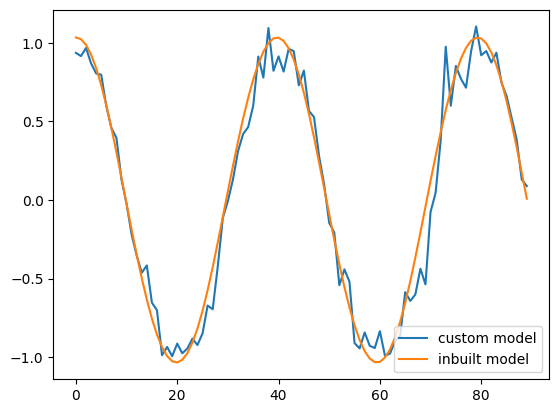

In [ ]:
## Original Code from TorchLeet ##
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate synthetic sequential data
torch.manual_seed(42)
sequence_length = 10
num_samples = 100

# Create a sine wave dataset
X = torch.linspace(0, 4 * 3.14159, steps=num_samples).unsqueeze(1)
y = torch.sin(X)

# Prepare data for LSTM
def create_in_out_sequences(data, seq_length):
    in_seq = []
    out_seq = []
    for i in range(len(data) - seq_length):
        in_seq.append(data[i:i + seq_length])
        out_seq.append(data[i + seq_length])
    return torch.stack(in_seq), torch.stack(out_seq)

X_seq, y_seq = create_in_out_sequences(y, sequence_length)

class CustomLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super().__init__()
        weights_biases_init = lambda : (nn.Parameter(torch.randn(input_dim, hidden_units)),
                                        nn.Parameter(torch.randn(hidden_units, hidden_units)),
                                        nn.Parameter(torch.zeros(hidden_units)))
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.Wxi, self.Whi, self.bi = weights_biases_init()
        self.Wxf, self.Whf, self.bf = weights_biases_init()
        self.Wxo, self.Who, self.bo = weights_biases_init()
        self.Wxc, self.Whc, self.bc = weights_biases_init()
        self.fc = nn.Linear(hidden_units, 1)
        # print(self.Wxi.shape, self.Whi.shape, self.bi.shape)

    def forward(self, inputs, H_C=None):
        # print(inputs.shape, self.Wxi.shape)
        batch_size, seq_len, _ = inputs.shape
        if not H_C:
            H = torch.randn(batch_size, self.hidden_units)
            C = torch.randn(batch_size, self.hidden_units)
        else:
            H, C = H_C

        all_hidden_states = []
        for t in range(seq_len):
            X_t = inputs[:, t, :]
            # print(X.shape, self.Wxi.shape, self.Whi.shape, self.bi.shape)
            I_t = torch.sigmoid(torch.matmul(X_t, self.Wxi) + torch.matmul(H, self.Whi) + self.bi)
            F_t = torch.sigmoid(torch.matmul(X_t, self.Wxf) + torch.matmul(H, self.Whf) + self.bf)
            O_t = torch.sigmoid(torch.matmul(X_t, self.Wxo) + torch.matmul(H, self.Who) + self.bo)
            C_tilde = torch.tanh(torch.matmul(X_t, self.Wxc) + torch.matmul(H, self.Whc) + self.bc)
            C = F_t * C + I_t * C_tilde
            H = O_t * torch.tanh(C)
            # print(H.shape)
            all_hidden_states.append(H.unsqueeze(1))

        outputs = torch.cat(all_hidden_states, dim=1)
        pred = self.fc(outputs)
        # print(pred.shape)
        return pred, (H, C)

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the LSTM
        return out

# Initialize the model, loss function, and optimizer
model_custom = CustomLSTMModel(1, 50)
model_inbuilt = LSTMModel()
criterion = nn.MSELoss()
optimizer_custom = optim.Adam(model_custom.parameters(), lr=0.01)
optimizer_inbuilt = optim.Adam(model_inbuilt.parameters(), lr=0.01)

# Training loop for the custom model
epochs = 500
for epoch in range(epochs):
    # Forward pass
    state = None
    pred, state = model_custom(X_seq, state)
    loss = criterion(pred[:, -1, :], y_seq) # Use the last output of the LSTM
    # Backward pass and optimization
    optimizer_custom.zero_grad()
    loss.backward()
    optimizer_custom.step()

    # Log progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Training loop for the inbuilt model
epochs = 500
for epoch in range(epochs):
    # Forward pass
    pred = model_inbuilt(X_seq)
    loss = criterion(pred, y_seq)
    # Backward pass and optimization
    optimizer_inbuilt.zero_grad()
    loss.backward()
    optimizer_inbuilt.step()

    # Log progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Testing on new data
test_steps = 100  # Ensure this is greater than sequence_length
X_test = torch.linspace(0, 5 * 3.14159, steps=test_steps).unsqueeze(1)
y_test = torch.sin(X_test)

# Create test input sequences
X_test_seq, _ = create_in_out_sequences(y_test, sequence_length)

with torch.no_grad():
    pred_custom, _ = model_custom(X_test_seq)
    pred_inbuilt = model_inbuilt(X_test_seq)
pred_custom = torch.flatten(pred_custom[:, -1, :])
pred_inbuilt = pred_inbuilt.squeeze()
print(f"Predictions with Custom Model for new sequence: {pred_custom.tolist()}")
print(f"Predictions with In-Built Model: {pred_inbuilt.tolist()}")

#Plot the predictions
plt.figure()
# plt.plot(y_test, label="Ground Truth")
plt.plot(pred_custom, label="custom model")
plt.plot(pred_inbuilt, label="inbuilt model")
plt.legend()
plt.show()


In [ ]:
## Strong LLM - o3-mini-high

import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt

from flax import linen as nn
from flax.training import train_state

# ----------------------------
# Data Preparation
# ----------------------------
# Set random seed for numpy (JAX’s PRNG is used in the models)
np.random.seed(42)
sequence_length = 10
num_samples = 100

# Create a sine wave dataset
X_vals = np.linspace(0, 4 * np.pi, num_samples).reshape(-1, 1)
y_vals = np.sin(X_vals)

def create_in_out_sequences(data, seq_length):
    in_seq = []
    out_seq = []
    # data is assumed to be of shape (N, 1)
    for i in range(len(data) - seq_length):
        in_seq.append(data[i:i + seq_length])
        out_seq.append(data[i + seq_length])
    return jnp.array(in_seq), jnp.array(out_seq)

X_seq, y_seq = create_in_out_sequences(y_vals, sequence_length)  # shapes: (num_samples-seq_length, seq_length, 1) and (num_samples-seq_length, 1)

# ----------------------------
# Custom LSTM Model (Hand-Coded)
# ----------------------------
class CustomLSTMModel(nn.Module):
    input_dim: int
    hidden_units: int

    @nn.compact
    def __call__(self, inputs, H_C=None):
        """
        inputs: shape (batch, seq_len, input_dim)
        H_C: tuple of (H, C); if None, initialize with random normal values using the "lstm" RNG.
        Returns:
          pred: predictions of shape (batch, seq_len, 1)
          (H, C): the final hidden and cell states.
        """
        batch_size, seq_len, _ = inputs.shape
        if H_C is None:
            # Use the "lstm" rng to generate initial states.
            key = self.make_rng("lstm")
            key_H, key_C = jax.random.split(key)
            H = jax.random.normal(key_H, (batch_size, self.hidden_units))
            C = jax.random.normal(key_C, (batch_size, self.hidden_units))
        else:
            H, C = H_C

        # Initialize gate parameters. (Each gate uses a weight matrix for input and hidden state, plus a bias.)
        Wxi = self.param("Wxi", nn.initializers.normal(), (self.input_dim, self.hidden_units))
        Whi = self.param("Whi", nn.initializers.normal(), (self.hidden_units, self.hidden_units))
        bi  = self.param("bi", nn.initializers.zeros, (self.hidden_units,))

        Wxf = self.param("Wxf", nn.initializers.normal(), (self.input_dim, self.hidden_units))
        Whf = self.param("Whf", nn.initializers.normal(), (self.hidden_units, self.hidden_units))
        bf  = self.param("bf", nn.initializers.zeros, (self.hidden_units,))

        Wxo = self.param("Wxo", nn.initializers.normal(), (self.input_dim, self.hidden_units))
        Who = self.param("Who", nn.initializers.normal(), (self.hidden_units, self.hidden_units))
        bo  = self.param("bo", nn.initializers.zeros, (self.hidden_units,))

        Wxc = self.param("Wxc", nn.initializers.normal(), (self.input_dim, self.hidden_units))
        Whc = self.param("Whc", nn.initializers.normal(), (self.hidden_units, self.hidden_units))
        bc  = self.param("bc", nn.initializers.zeros, (self.hidden_units,))

        dense = nn.Dense(features=1)

        outputs = []
        for t in range(seq_len):
            X_t = inputs[:, t, :]  # (batch, input_dim)
            I_t = jax.nn.sigmoid(jnp.dot(X_t, Wxi) + jnp.dot(H, Whi) + bi)
            F_t = jax.nn.sigmoid(jnp.dot(X_t, Wxf) + jnp.dot(H, Whf) + bf)
            O_t = jax.nn.sigmoid(jnp.dot(X_t, Wxo) + jnp.dot(H, Who) + bo)
            C_tilde = jnp.tanh(jnp.dot(X_t, Wxc) + jnp.dot(H, Whc) + bc)
            C = F_t * C + I_t * C_tilde
            H = O_t * jnp.tanh(C)
            outputs.append(H)
        outputs = jnp.stack(outputs, axis=1)  # shape (batch, seq_len, hidden_units)
        pred = dense(outputs)  # shape (batch, seq_len, 1)
        return pred, (H, C)

# ----------------------------
# Built-In LSTM Model using Flax's LSTMCell
# ----------------------------
class LSTMModel(nn.Module):
    hidden_size: int = 50

    @nn.compact
    def __call__(self, inputs):
        """
        inputs: shape (batch, seq_len, input_dim) where input_dim is assumed to be 1.
        The LSTM cell is applied over the time axis; the final hidden state is passed through a Dense layer.
        Returns:
          out: predictions of shape (batch, 1)
        """
        batch_size, seq_len, _ = inputs.shape
        # Initialize carry for the LSTM cell.
        carry = nn.LSTMCell.initialize_carry(self.make_rng("lstm"), (batch_size,), self.hidden_size)
        lstm_cell = nn.LSTMCell()
        outputs = []
        for t in range(seq_len):
            carry, y = lstm_cell(carry, inputs[:, t, :])
            outputs.append(y)
        outputs = jnp.stack(outputs, axis=1)  # shape (batch, seq_len, hidden_size)
        dense = nn.Dense(features=1)
        out = dense(outputs[:, -1, :])  # use the last output for prediction
        return out

# ----------------------------
# Training Utilities
# ----------------------------
# A simple TrainState to hold parameters and the optimizer state.
class TrainState(train_state.TrainState):
    pass

# Loss functions
def loss_fn_custom(params, rng, batch_x, batch_y):
    # Model returns a sequence of predictions; we use the last time-step.
    pred, _ = custom_model.apply({"params": params}, batch_x, rngs={"lstm": rng})
    pred_last = pred[:, -1, 0]  # shape (batch,)
    loss = jnp.mean((pred_last - batch_y.squeeze()) ** 2)
    return loss

def loss_fn_builtin(params, rng, batch_x, batch_y):
    pred = lstm_model.apply({"params": params}, batch_x, rngs={"lstm": rng})
    pred = pred.squeeze()  # shape (batch,)
    loss = jnp.mean((pred - batch_y.squeeze()) ** 2)
    return loss

# Training steps (jitted)
@jax.jit
def train_step_custom(state, batch_x, batch_y, rng):
    loss, grads = jax.value_and_grad(loss_fn_custom)(state.params, rng, batch_x, batch_y)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def train_step_builtin(state, batch_x, batch_y, rng):
    loss, grads = jax.value_and_grad(loss_fn_builtin)(state.params, rng, batch_x, batch_y)
    state = state.apply_gradients(grads=grads)
    return state, loss

# ----------------------------
# Initialize Models and Optimizers
# ----------------------------
# Create instances of both models.
custom_model = CustomLSTMModel(input_dim=1, hidden_units=50)
lstm_model = LSTMModel(hidden_size=50)

# Initialize parameters by “calling” the model once with a sample input.
dummy_input_custom = jnp.ones((X_seq.shape[0], sequence_length, 1))
dummy_input_builtin = jnp.ones((X_seq.shape[0], sequence_length, 1))

rng_custom = jax.random.PRNGKey(0)
rng_builtin = jax.random.PRNGKey(1)

params_custom = custom_model.init({"params": rng_custom, "lstm": rng_custom}, dummy_input_custom)["params"]
params_builtin = lstm_model.init({"params": rng_builtin, "lstm": rng_builtin}, dummy_input_builtin)["params"]

# Create training states with Adam optimizer (learning rate = 0.01).
optimizer = optax.adam(0.01)
state_custom = TrainState.create(apply_fn=custom_model.apply, params=params_custom, tx=optimizer)
state_builtin = TrainState.create(apply_fn=lstm_model.apply, params=params_builtin, tx=optimizer)

# ----------------------------
# Training Loop for Custom LSTM Model
# ----------------------------
epochs = 500
rng = jax.random.PRNGKey(42)
for epoch in range(epochs):
    rng, step_rng = jax.random.split(rng)
    state_custom, loss_value = train_step_custom(state_custom, X_seq, y_seq, step_rng)
    if (epoch + 1) % 50 == 0:
        print(f"[Custom LSTM] Epoch [{epoch + 1}/{epochs}], Loss: {loss_value:.4f}")

# ----------------------------
# Training Loop for Built-In LSTM Model
# ----------------------------
rng = jax.random.PRNGKey(100)
for epoch in range(epochs):
    rng, step_rng = jax.random.split(rng)
    state_builtin, loss_value = train_step_builtin(state_builtin, X_seq, y_seq, step_rng)
    if (epoch + 1) % 50 == 0:
        print(f"[Built-In LSTM] Epoch [{epoch + 1}/{epochs}], Loss: {loss_value:.4f}")

# ----------------------------
# Testing on New Data
# ----------------------------
test_steps = 100  # should be greater than sequence_length
X_test = np.linspace(0, 5 * np.pi, test_steps).reshape(-1, 1)
y_test = np.sin(X_test)
X_test_seq, _ = create_in_out_sequences(y_test, sequence_length)  # (test_steps-seq_length, seq_length, 1)

# Get predictions from both models.
rng, custom_test_rng = jax.random.split(rng)
pred_custom, _ = custom_model.apply({"params": state_custom.params}, X_test_seq, rngs={"lstm": custom_test_rng})
# Use the last time-step predictions (flattened)
pred_custom = pred_custom[:, -1, 0]

rng, builtin_test_rng = jax.random.split(rng)
pred_builtin = lstm_model.apply({"params": state_builtin.params}, X_test_seq, rngs={"lstm": builtin_test_rng})
pred_builtin = pred_builtin.squeeze()

print("Predictions with Custom Model for new sequence:")
print(np.array(pred_custom))
print("\nPredictions with Built-In Model:")
print(np.array(pred_builtin))

# ----------------------------
# Plot the predictions
# ----------------------------
plt.figure(figsize=(8, 4))
plt.plot(pred_custom, label="Custom LSTM Model")
plt.plot(pred_builtin, label="Built-In LSTM Model")
plt.legend()
plt.title("Predictions on New Sine Wave Sequence")
plt.xlabel("Time step")
plt.ylabel("Predicted value")
plt.show()


In [ ]:
## Weak LLM - o4-mini
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap, lax  # MODIFIED import for lax
from flax import linen as nn
import optax

# Function to generate random weights with explicit PRNG key (JAX-RANDOM-001)
def generate_random_weights(shape, key):  # MODIFIED to accept key
    return random.normal(key, shape)

# LSTM step function
def lstm_step(hidden_state, cell_state, input_data):
    # Logic for LSTM step
    # For simplicity, using a basic linear transformation and state update
    new_hidden_state = jnp.tanh(jnp.dot(input_data, hidden_state) + cell_state)  # Example operation
    new_cell_state = cell_state  # Update cell state logic as needed
    return new_hidden_state, new_cell_state  # Return new states

# Function that wraps the LSTM for batching
def lstm_forward(inputs, hidden_state, cell_state):
    def step_fn(carry, x):
        hidden_state, cell_state = carry
        return lstm_step(hidden_state, cell_state, x), (hidden_state, cell_state)

    # Correctly use jax.lax.scan with initial state as a tuple of hidden_state and cell_state (JAX-SCAN-001)
    final_hidden_state, _ = lax.scan(step_fn, (hidden_state, cell_state), inputs)
    return final_hidden_state  # Return the final hidden state

# Loss function
def loss_fn(params, model, X_seq, y_seq):
    # Compute loss over the model prediction and actual sequence
    predicted = model.apply(params, X_seq)  # Example model application
    return jnp.mean((predicted - y_seq) ** 2)  # Example loss calculation

# Main function
def main():
    # Initialize model parameters and PRNG key
    key = random.PRNGKey(0)  # MODIFIED to initialize PRNG key
    params = generate_random_weights((10, 10), key)  # Example parameter initialization
    optimizer = optax.adam(learning_rate=1e-3)

    # Example sequence input and target
    X_seq = jnp.ones((5, 10))  # Example input sequence
    y_seq = jnp.ones((5, 10))  # Example target sequence
    hidden_state = jnp.zeros((10,))  # Initialize hidden state
    cell_state = jnp.zeros((10,))  # Initialize cell state

    # Compile the loss function
    loss_value, grads = jax.value_and_grad(loss_fn)(params, lstm_forward, X_seq, y_seq)
    loss_value, grads = jax.value_and_grad(loss_fn)(
    params,
    lambda x: lstm_forward(X_seq, hidden_state, cell_state),
    cell_state,
    y_seq
)
    # Update parameters using the optimizer
    updates, opt_state = optimizer.update(grads, optax.OptState(0))  # Correct usage
    params = optax.apply_updates(params, updates)

    epochs = 500
    for epoch in range(epochs):
        # Compute gradients and update model parameters
        loss_value, grads = jax.value_and_grad(loss_fn)(params, lambda x: lstm_forward(X_seq, hidden_state, cell_state), y_seq)  # MODIFIED to wrap the model call
        updates, opt_state = optimizer.update(grads, optax.OptState(0))
        params = optax.apply_updates(params, updates)
        if epoch % 50 == 0:  # Print loss every 50 epochs
            print(f'Epoch {epoch}, Loss: {loss_value}')

if __name__ == "__main__":
    main()  # Entry point for the program

AttributeError: 'function' object has no attribute 'apply'

In [ ]:
"""Error Code

loss_value, grads = jax.value_and_grad(loss_fn)(params, lambda x: lstm_forward(X_seq, hidden_state, cell_state), y_seq)

Error:
TypeError: loss_fn() missing 1 required positional argument: 'y_seq'

Fix Guide
loss_fn function expects four arguments (params, model, X_seq, y_seq), but the jax.value_and_grad call doesn't properly align the arguments when using a lambda function. So adjust the jax.value_and_grad call to explicitly pass all required arguments to loss_fn

Correct Code
loss_value, grads = jax.value_and_grad(loss_fn)(params, lstm_forward, X_seq, y_seq)
"""

"""
Error Code
predicted = model.apply(params, X_seq)

Error:
AttributeError: 'function' object has no attribute 'apply'

Fix Guide
adjust the loss_fn function to call model as a regular function instead of using .apply. Since lstm_forward takes inputs, hidden_state, and cell_state as arguments, we’ll need to pass those explicitly in the loss_fn function

Correct Code
predicted = model(X_seq, hidden_state, cell_state)
"""

"""
Error Code
final_hidden_state, _ = lax.scan(step_fn, (hidden_state, cell_state), inputs)
return final_hidden_state
Error
TypeError: unsupported operand type(s) for -: 'tuple' and 'ArrayImpl'

Fix Guide
ensure lstm_forward returns an array (the sequence of hidden states) instead of a tuple. In the current setup, lstm_forward should return the stacked outputs from lax.scan (the second element of the tuple), not the final carry.

Correct Code
_, outputs = lax.scan(step_fn, (hidden_state, cell_state), inputs)
"""

"""Error Code
loss_value, grads = jax.value_and_grad(loss_fn)(params,lambda x: lstm_forward(X_seq, hidden_state, cell_state), cell_state, y_seq)

Error:
TypeError: main.<locals>.<lambda>() takes 1 positional argument but 3 were given

Fix guide
the model argument is a lambda function lambda x: lstm_forward(X_seq, hidden_state, cell_state), which expects a single argument x. However, in loss_fn, the model is called with three arguments: model(X_seq, hidden_state, cell_state). The first jax.value_and_grad call uses lstm_forward directly and works correctly (as it accepts X_seq, hidden_state, and cell_state), we can replace the lambda function in the second call with lstm_forward. Replace the lambda function lambda x: lstm_forward(X_seq, hidden_state, cell_state) with lstm_forward directly and passed all arguments (params, lstm_forward, X_seq, y_seq, hidden_state, cell_state) to match loss_fn's signature.
Correct Code
loss_value, grads = jax.value_and_grad(loss_fn)(params, lstm_forward, X_seq, y_seq, hidden_state, cell_state)
"""

"""Error Code
updates, opt_state = optimizer.update(grads, optax.OptState(0))

Error
TypeError: Cannot instantiate typing.Union

Fix guide
Initialize the optimizer state properly using optimizer.init(params) before the training loop.
Pass the initialized opt_state to optimizer.update instead of creating a new optax.OptState(0) each time.

Fixed Code
opt_state = optimizer.init(params) # Initialize
updates, opt_state = optimizer.update(grads, opt_state) # Use
"""

'Error Code\nupdates, opt_state = optimizer.update(grads, optax.OptState(0))\n\n\n'

In [ ]:
# # Fixed Code #1
# import jax
# import jax.numpy as jnp
# from jax import random, grad, jit, vmap, lax  # MODIFIED import for lax
# from flax import linen as nn
# import optax

# # Function to generate random weights with explicit PRNG key (JAX-RANDOM-001)
# def generate_random_weights(shape, key):  # MODIFIED to accept key
#     return random.normal(key, shape)

# # LSTM step function
# def lstm_step(hidden_state, cell_state, input_data):
#     # Logic for LSTM step
#     # For simplicity, using a basic linear transformation and state update
#     new_hidden_state = jnp.tanh(jnp.dot(input_data, hidden_state) + cell_state)  # Example operation
#     new_cell_state = cell_state  # Update cell state logic as needed
#     return new_hidden_state, new_cell_state  # Return new states

# # Function that wraps the LSTM for batching
# def lstm_forward(inputs, hidden_state, cell_state):
#     def step_fn(carry, x):
#         hidden_state, cell_state = carry
#         return lstm_step(hidden_state, cell_state, x), (hidden_state, cell_state)

#     # Correctly use jax.lax.scan with initial state as a tuple of hidden_state and cell_state (JAX-SCAN-001)
#     # final_hidden_state, _ = lax.scan(step_fn, (hidden_state, cell_state), inputs)
#     _, outputs = lax.scan(step_fn, (hidden_state, cell_state), inputs)
#     # return final_hidden_state  # Return the final hidden state
#     return outputs[0]
# # Loss function
# # --- FIX APPLIED HERE ---
# # Original (causing error):
# # def loss_fn(params, model, X_seq, y_seq):
# #     predicted = model.apply(params, X_seq)  # Example model application
# #     return jnp.mean((predicted - y_seq) ** 2)  # Example loss calculation
# # Fixed:
# def loss_fn(params, model, X_seq, y_seq, hidden_state, cell_state):
#     predicted = model(X_seq, hidden_state, cell_state)  # Call model as a function
#     return jnp.mean((predicted - y_seq) ** 2)  # Example loss calculation
# # --- END OF FIX ---

# # Main function
# def main():
#     # Initialize model parameters and PRNG key
#     key = random.PRNGKey(0)  # MODIFIED to initialize PRNG key
#     params = generate_random_weights((10, 10), key)  # Example parameter initialization
#     optimizer = optax.adam(learning_rate=1e-3)

#     # Example sequence input and target
#     X_seq = jnp.ones((5, 10))  # Example input sequence
#     y_seq = jnp.ones((5, 10))  # Example target sequence
#     hidden_state = jnp.zeros((10,))  # Initialize hidden state
#     cell_state = jnp.zeros((10,))  # Initialize cell state

#     # Compile the loss function
#     # Adjusted to pass hidden_state and cell_state
#     loss_value, grads = jax.value_and_grad(loss_fn)(params, lstm_forward, X_seq, y_seq, hidden_state, cell_state)
#     opt_state = optimizer.init(params)
#     # loss_value, grads = jax.value_and_grad(loss_fn)(
#     #     params,
#     #     lambda x: lstm_forward(X_seq, hidden_state, cell_state),
#     #     cell_state,
#     #     hidden_state,
#     #     cell_state,
#     #     y_seq
#     # )
#     # Update parameters using the optimizer
#     updates, opt_state = optimizer.update(grads, opt_state)
#     # updates, opt_state = optimizer.update(grads, optax.OptState(0))  # Correct usage
#     params = optax.apply_updates(params, updates)

#     epochs = 500
#     for epoch in range(epochs):
#         # Compute gradients and update model parameters
#         # Adjusted to pass hidden_state and cell_state
#         loss_value, grads = jax.value_and_grad(loss_fn)(params, lstm_forward, X_seq, y_seq, hidden_state, cell_state)
#         # updates, opt_state = optimizer.update(grads, optax.OptState(0))
#         updates, opt_state = optimizer.update(grads, opt_state)
#         params = optax.apply_updates(params, updates)
#         if epoch % 50 == 0:  # Print loss every 50 epochs
#             print(f'Epoch {epoch}, Loss: {loss_value}')

# if __name__ == "__main__":
#     main()  # Entry point for the program

Epoch 0, Loss: 1.0
Epoch 50, Loss: 1.0
Epoch 100, Loss: 1.0
Epoch 150, Loss: 1.0
Epoch 200, Loss: 1.0
Epoch 250, Loss: 1.0
Epoch 300, Loss: 1.0
Epoch 350, Loss: 1.0
Epoch 400, Loss: 1.0
Epoch 450, Loss: 1.0


Custom Model - Epoch [50/500], Loss: 0.0016
Custom Model - Epoch [100/500], Loss: 0.0004
Custom Model - Epoch [150/500], Loss: 0.0002
Custom Model - Epoch [200/500], Loss: 0.0001
Custom Model - Epoch [250/500], Loss: 0.0000
Custom Model - Epoch [300/500], Loss: 0.0000
Custom Model - Epoch [350/500], Loss: 0.0000
Custom Model - Epoch [400/500], Loss: 0.0000
Custom Model - Epoch [450/500], Loss: 0.0000
Custom Model - Epoch [500/500], Loss: 0.0000
In-Built Model - Epoch [50/500], Loss: 0.0010
In-Built Model - Epoch [100/500], Loss: 0.0000
In-Built Model - Epoch [150/500], Loss: 0.0000
In-Built Model - Epoch [200/500], Loss: 0.0000
In-Built Model - Epoch [250/500], Loss: 0.0000
In-Built Model - Epoch [300/500], Loss: 0.0000
In-Built Model - Epoch [350/500], Loss: 0.0000
In-Built Model - Epoch [400/500], Loss: 0.0000
In-Built Model - Epoch [450/500], Loss: 0.0000
In-Built Model - Epoch [500/500], Loss: 0.0000
Predictions with Custom Model for new sequence: [1.0308150053024292, 1.01915109157

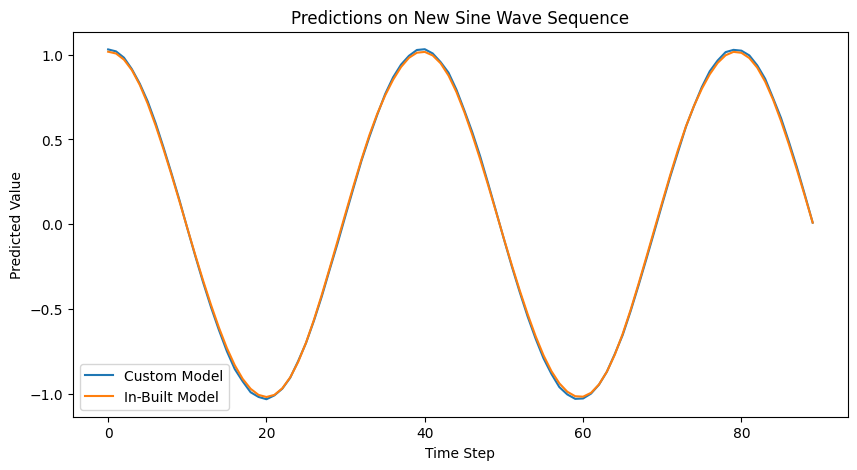

In [1]:
## Fixed Code #2
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
import optax
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Data Preparation
# ---------------------------
sequence_length = 10
num_samples = 100

# Create a sine wave dataset
X = jnp.linspace(0, 4 * np.pi, num_samples).reshape(-1, 1)
y = jnp.sin(X)

def create_in_out_sequences(data, seq_length):
    in_seq = []
    out_seq = []
    for i in range(len(data) - seq_length):
        in_seq.append(data[i:i+seq_length])
        out_seq.append(data[i+seq_length])
    return jnp.stack(in_seq), jnp.stack(out_seq)

X_seq, y_seq = create_in_out_sequences(y, sequence_length)
# X_seq shape: (num_samples - sequence_length, sequence_length, 1)
# y_seq shape: (num_samples - sequence_length, 1)

# ---------------------------
# Custom LSTM Model
# ---------------------------
class CustomLSTMModel(nn.Module):
    input_dim: int
    hidden_units: int

    def setup(self):
        # Helper function to initialize weights and biases for one gate
        def weights_biases_init(prefix):
            W = self.param(prefix + "_W", nn.initializers.normal(), (self.input_dim, self.hidden_units))
            U = self.param(prefix + "_U", nn.initializers.normal(), (self.hidden_units, self.hidden_units))
            b = self.param(prefix + "_b", nn.initializers.zeros, (self.hidden_units,))
            return W, U, b
        # Initialize parameters for each gate: input, forget, output, and candidate
        self.Wxi, self.Whi, self.bi = weights_biases_init("input")
        self.Wxf, self.Whf, self.bf = weights_biases_init("forget")
        self.Wxo, self.Who, self.bo = weights_biases_init("output")
        self.Wxc, self.Whc, self.bc = weights_biases_init("candidate")
        self.fc = nn.Dense(features=1)

    def __call__(self, inputs, state=None):
        batch_size, seq_len, _ = inputs.shape
        if state is None:
            # Use the module’s "lstm" RNG to initialize the hidden and cell states
            H = jax.random.normal(self.make_rng("lstm"), (batch_size, self.hidden_units))
            C = jax.random.normal(self.make_rng("lstm"), (batch_size, self.hidden_units))
        else:
            H, C = state

        all_hidden_states = []
        for t in range(seq_len):
            X_t = inputs[:, t, :]  # shape: (batch_size, input_dim)
            I_t = jax.nn.sigmoid(jnp.dot(X_t, self.Wxi) + jnp.dot(H, self.Whi) + self.bi)
            F_t = jax.nn.sigmoid(jnp.dot(X_t, self.Wxf) + jnp.dot(H, self.Whf) + self.bf)
            O_t = jax.nn.sigmoid(jnp.dot(X_t, self.Wxo) + jnp.dot(H, self.Who) + self.bo)
            C_tilde = jnp.tanh(jnp.dot(X_t, self.Wxc) + jnp.dot(H, self.Whc) + self.bc)
            C = F_t * C + I_t * C_tilde
            H = O_t * jnp.tanh(C)
            all_hidden_states.append(H[:, None, :])
        outputs = jnp.concatenate(all_hidden_states, axis=1)  # shape: (batch_size, seq_len, hidden_units)
        pred = self.fc(outputs)  # shape: (batch_size, seq_len, 1)
        return pred, (H, C)

# ---------------------------
# In-Built LSTM Model using Flax's LSTMCell
# ---------------------------
class LSTMModel(nn.Module):
    hidden_size: int = 50

    def setup(self):
        self.lstm = nn.LSTMCell(features=self.hidden_size)
        self.fc = nn.Dense(features=1)

    def __call__(self, inputs):
        batch_size, seq_len, _ = inputs.shape
        input_shape = (batch_size,)
        carry = self.lstm.initialize_carry(self.make_rng("lstm"), input_shape)
        outputs = []
        for t in range(seq_len):
            carry, out = self.lstm(carry, inputs[:, t, :])
            outputs.append(out)
        outputs = jnp.stack(outputs, axis=1)
        out = self.fc(outputs[:, -1, :])
        return out

# ---------------------------
# Training: Custom LSTM Model
# ---------------------------
custom_model = CustomLSTMModel(input_dim=1, hidden_units=50)
rng_custom = random.PRNGKey(42)
# Initialize parameters (pass both 'params' and 'lstm' RNGs)
params_custom = custom_model.init({"params": rng_custom, "lstm": rng_custom}, X_seq)["params"]
optimizer_custom = optax.adam(0.01)
opt_state_custom = optimizer_custom.init(params_custom)

def loss_fn_custom(params, X_seq, y_seq, rng):
    pred, _ = custom_model.apply({"params": params}, X_seq, rngs={"lstm": rng})
    # Use the last time step's output for computing loss
    loss = jnp.mean((pred[:, -1, :] - y_seq) ** 2)
    return loss

epochs = 500
for epoch in range(epochs):
    rng_custom, subkey = random.split(rng_custom)
    loss_value, grads = jax.value_and_grad(loss_fn_custom)(params_custom, X_seq, y_seq, subkey)
    updates, opt_state_custom = optimizer_custom.update(grads, opt_state_custom)
    params_custom = optax.apply_updates(params_custom, updates)
    if (epoch + 1) % 50 == 0:
        print(f"Custom Model - Epoch [{epoch+1}/500], Loss: {loss_value:.4f}")

# ---------------------------
# Training: In-Built LSTM Model
# ---------------------------
inbuilt_model = LSTMModel(hidden_size=50)
rng_inbuilt = random.PRNGKey(0)
params_inbuilt = inbuilt_model.init({"params": rng_inbuilt, "lstm": rng_inbuilt}, X_seq)["params"]
optimizer_inbuilt = optax.adam(0.01)
opt_state_inbuilt = optimizer_inbuilt.init(params_inbuilt)

def loss_fn_inbuilt(params, X_seq, y_seq, rng):
    pred = inbuilt_model.apply({"params": params}, X_seq, rngs={"lstm": rng})
    loss = jnp.mean((pred - y_seq) ** 2)
    return loss

for epoch in range(epochs):
    rng_inbuilt, subkey = random.split(rng_inbuilt)
    loss_value, grads = jax.value_and_grad(loss_fn_inbuilt)(params_inbuilt, X_seq, y_seq, subkey)
    updates, opt_state_inbuilt = optimizer_inbuilt.update(grads, opt_state_inbuilt)
    params_inbuilt = optax.apply_updates(params_inbuilt, updates)
    if (epoch + 1) % 50 == 0:
        print(f"In-Built Model - Epoch [{epoch+1}/500], Loss: {loss_value:.4f}")

# ---------------------------
# Testing on New Data
# ---------------------------
test_steps = 100  # Must be greater than sequence_length
X_test = jnp.linspace(0, 5 * np.pi, test_steps).reshape(-1, 1)
y_test = jnp.sin(X_test)
X_test_seq, _ = create_in_out_sequences(y_test, sequence_length)

# Get predictions from both models.
rng_custom, subkey = random.split(rng_custom)
pred_custom, _ = custom_model.apply({"params": params_custom}, X_test_seq, rngs={"lstm": subkey})
pred_custom = jnp.squeeze(pred_custom[:, -1, :])

rng_inbuilt, subkey = random.split(rng_inbuilt)
pred_inbuilt = inbuilt_model.apply({"params": params_inbuilt}, X_test_seq, rngs={"lstm": subkey})
pred_inbuilt = jnp.squeeze(pred_inbuilt)

print("Predictions with Custom Model for new sequence:", pred_custom.tolist())
print("Predictions with In-Built Model:", pred_inbuilt.tolist())

# ---------------------------
# Plot the Predictions
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(pred_custom, label="Custom Model")
plt.plot(pred_inbuilt, label="In-Built Model")
plt.legend()
plt.title("Predictions on New Sine Wave Sequence")
plt.xlabel("Time Step")
plt.ylabel("Predicted Value")
plt.show()
